# 기계학습 (60점)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display, HTML
import datetime

warnings.filterwarnings('ignore')
display(HTML('<stlye>:root {--jp-notebook-max-width:3000px;}</style'))
display(HTML('<style>.container {width:100% !important}</style>'))
display(HTML('<style>.prompt {display:None !important}</style>'))

In [4]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [5]:
pd.set_option('display.max_columns', None)

### 비트코인 데이터

데이터 경로 : './data/bitcoin_mock.csv'

1분간격의 비트코인 가격에 대한 정보이다. 
- datetime: 1분 단위의 데이터
- open : 시작가
- high : 최고가
- low : 최저가
- close : 종가
- volume : 거래량

In [4]:
import pandas as pd
df =pd.read_csv('./data/bitcoin_mock.csv')
df.head()

,datetime,open,high,low,close,volume
0,2022-01-01 00:00:00,46216.93,46271.08,46208.37,46250.00,40.57574
1,2022-01-01 00:01:00,46250.00,46344.23,46234.39,46312.76,42.38106
2,2022-01-01 00:02:00,46312.76,46381.69,46292.75,46368.73,51.29955
3,2022-01-01 00:03:00,46368.73,46391.49,46314.26,46331.08,30.45894
4,2022-01-01 00:04:00,46331.07,46336.10,46300.00,46321.34,20.96029


### 기계학습1
모든 데이터 행이 1분간격으로 존재하는지 확인하고 그렇지 않은 경우 누락된 시각의 행을 생성하고 컬럼들의 결측치를 적절히 생성하라.      
결측치가 존재한다면 결측치를 처리하라

In [8]:
s = (pd.to_datetime(df['datetime']) - pd.to_datetime(df['datetime'].shift(1)))
s.unique()

array([       'NaT',  60000000000, 120000000000], dtype='timedelta64[ns]')

In [18]:
s[s == datetime.timedelta(minutes = 2)].index

Int64Index([ 21440,  21757,  73347, 117580, 128033, 148204, 167296, 176478,
            188309, 229511, 246312, 293361, 294091, 365199, 371389, 401645,
            412633, 413808, 436955, 457592, 470904, 491242, 491733, 513277,
            575932],
           dtype='int64')

In [38]:
df2 = pd.DataFrame(pd.to_datetime(df.iloc[s[s == datetime.timedelta(minutes = 2)].index]['datetime']) - datetime.timedelta(minutes = 1), columns = ['datetime']).reset_index(drop = True)
#df2 = df2.datetime.astype('str')

In [85]:
df3 = pd.concat((df, df2), axis = 0).reset_index(drop = True)
df3['datetime'] = df3['datetime'].astype('str')
df3 = df3.sort_values('datetime')
df4 = df3.interpolate()

In [86]:
df4.isnull().sum()

datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

### 기계학습2

t(분)까지 데이터가 확정된 시점에서 매도,매수를 판단하기 위한 알고리즘을 만들고 백테스팅을 진행하려한다.       
아래의 과정의 전처리를 시행하고 algorithm과 result 두 범주형 컬럼의 교차테이블을 출력하라

---
알고리즘
1. t(분)시점에서 close 값에 대한 t(분)시점의 5분,120분 이동평균값을 각각 't_5', 't_120'으로 컬럼으로 t-1(분)시점의 5분,120분 이동평균값을 각각 't-1_5', 't-1_120'으로 컬럼으로 만든다.
---
2. - t(분)시점에서 5분 이동평균값(t_5)은 120분 이동평균값(t_120)보다 높고 t-1의 5분 이동평균값(t-1_5)은 120분 이동평균값(t-1_120)보다 낮은 경우 : 'buy'   # 매수  
   - t(분)시점에서 5분 이동평균값(t_5)은 120분 이동평균값(t_120 보다 낮고 t-1의 5분 이동평균값(t-1_5)은 120분 이동평균값(t-1_120)보다 높은 경우 : 'sell'  # 매도
   - 그외 'stay'    
   
   위의 조건으로 buy(매수), sell(매도)를 판단하고 buy,sell,stay를 나타내는 새로운 컬럼 'algorithm'을 생성한다.
---         
3. t+10(분)의 open 값과 t(분)의 close값을 비교하여 새로운 컬럼 'result'를 만든다.
   - 여부가 'buy' 이고 t+10(분) open >= t(분) close : 'profit'
   - 여부가 'buy' 이고 t+10(분) open <  t(분) close : 'loss'
   - 여부가 'sell' 이고 t+10(분) open >= t(분) close : 'loss'
   - 여부가 'sell' 이고 t+10(분) open <  t(분) close : 'profit'
   - 여부가 'stay' 이면 : 'stay' 
   
   위의 조건으로 컬럼값을 채운다

In [92]:
df4['t_5'] = df4['close'].rolling(window = 5).mean()
df4['t_120'] = df4['close'].rolling(window = 120).mean()
df4['t-1_5'] = df4['close'].shift(1).rolling(window = 5).mean()
df4['t-1_120'] = df4['close'].shift(1).rolling(window = 120).mean()

In [106]:
df4['algorithm'] = np.NaN
df4['algorithm'][(df4['t_5'] > df4['t_120']) & (df4['t-1_5'] < df4['t-1_120'])] = 'buy'
df4['algorithm'][(df4['t_5'] < df4['t_120']) & (df4['t-1_5'] > df4['t-1_120'])] = 'sell'
df4['algorithm'] = df4['algorithm'].fillna('stay')
df4

,datetime,open,high,low,close,volume,t_5,t_120,t-1_5,t-1_120,algorithm
0,2022-01-01 00:00:00,46216.93,46271.08,46208.37,46250.00,40.57574,NaN,NaN,NaN,NaN,stay
1,2022-01-01 00:01:00,46250.00,46344.23,46234.39,46312.76,42.38106,NaN,NaN,NaN,NaN,stay
2,2022-01-01 00:02:00,46312.76,46381.69,46292.75,46368.73,51.29955,NaN,NaN,NaN,NaN,stay
3,2022-01-01 00:03:00,46368.73,46391.49,46314.26,46331.08,30.45894,NaN,NaN,NaN,NaN,stay
4,2022-01-01 00:04:00,46331.07,46336.10,46300.00,46321.34,20.96029,46316.782,NaN,NaN,NaN,stay
...,...,...,...,...,...,...,...,...,...,...,...
613123,2023-03-02 19:08:00,23476.11,23495.61,23467.11,23475.35,339.17422,23478.958,23315.954167,23480.868,23314.352250,stay
613124,2023-03-02 19:09:00,23475.35,23484.00,23456.38,23460.44,292.23280,23475.888,23317.540583,23478.958,23315.954167,stay
613125,2023-03-02 19:10:00,23460.44,23484.83,23460.44,23482.77,277.86291,23476.942,23319.328000,23475.888,23317.540583,stay
613126,2023-03-02 19:11:00,23482.77,23489.99,23470.17,23477.79,231.13719,23474.492,23321.095833,23476.942,23319.328000,stay


In [112]:
df4['t+10'] = df4['open'].shift(-10)
df4['result'] = np.NaN
df4['result'][(df4['algorithm'] == 'buy') & (df4['t+10'] >= df4['close'])] = 'profit'
df4['result'][(df4['algorithm'] == 'buy') & (df4['t+10'] < df4['close'])] = 'loss'
df4['result'][(df4['algorithm'] == 'sell') & (df4['t+10'] >= df4['close'])] = 'loss'
df4['result'][(df4['algorithm'] == 'sell') & (df4['t+10'] < df4['close'])] = 'profit'
df4['result'][df4['algorithm'] == 'stay']  = 'stay'

In [115]:
c_tab = pd.crosstab(df4['algorithm'], df4['result'])
c_tab

result,loss,profit,stay
algorithm,,,
buy,3756,3563,0
sell,3793,3526,0
stay,0,0,598515


### 기계학습3     
위에서 전처리한 데이터에 대해 아래 조건으로 그래프를 출력하라
1. 2022-01-01 08:00:00 ~ 2022-01-01 15:00:00 시간대의 close값의 선형 그래프
2. 위 시간대에 대해 algorithm 컬럼이 buy일 경우 빨간 수직선, sell일 경우 파란 수직선

<img src="./data/1.png" height='300' width='1200' style="float: left; margin-right: 10px;">

In [123]:
df5 = df4[(df4['datetime'] >= '2022-01-01 08:00:00') & (df4['datetime'] <= '2022-01-01 15:00:00')]
df5

,datetime,open,high,low,close,volume,t_5,t_120,t-1_5,t-1_120,algorithm,t+10,result
480,2022-01-01 08:00:00,47194.73,47228.86,47174.27,47174.28,7.95682,47180.820,47095.909167,47168.932,47096.070667,stay,47092.03,stay
481,2022-01-01 08:01:00,47174.28,47174.28,47117.76,47125.88,12.63977,47177.400,47095.608917,47180.820,47095.909167,stay,47098.99,stay
482,2022-01-01 08:02:00,47125.88,47155.13,47113.60,47131.31,24.27260,47171.180,47095.257333,47177.400,47095.608917,stay,47108.17,stay
483,2022-01-01 08:03:00,47131.31,47154.27,47118.67,47131.00,3.81929,47151.440,47095.043583,47171.180,47095.257333,stay,47122.47,stay
484,2022-01-01 08:04:00,47131.01,47163.19,47125.08,47153.78,12.99805,47143.250,47095.400000,47151.440,47095.043583,stay,47090.55,stay
...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,2022-01-01 14:56:00,46950.00,46961.94,46950.00,46953.46,2.75428,46948.796,47019.712667,46944.250,47020.649000,stay,46974.01,stay
897,2022-01-01 14:57:00,46953.46,46956.14,46930.00,46930.01,39.05174,46947.810,47018.587333,46948.796,47019.712667,stay,46994.39,stay
898,2022-01-01 14:58:00,46930.01,46945.00,46895.40,46942.62,36.05454,46945.500,47017.090417,46947.810,47018.587333,stay,46973.61,stay
899,2022-01-01 14:59:00,46942.62,46959.99,46920.01,46926.22,8.86584,46940.462,47015.858500,46945.500,47017.090417,stay,46994.45,stay


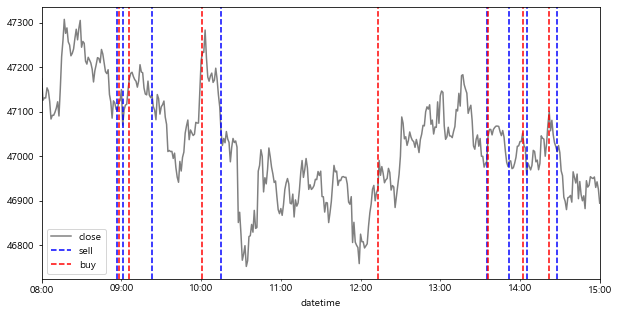

In [170]:
fig ,ax = plt.subplots(figsize = (10,5))
df5['datetime'] = pd.to_datetime(df5['datetime'])
df5[['datetime', 'close']].plot(x = 'datetime', color = 'gray', ax = ax)
for data in df5[df5['algorithm'] != 'stay'][['datetime', 'algorithm']].values:
    time = data[0]
    al = data[1]
    if al == 'buy':
        ax.axvline(time, linestyle = '--', c = 'red', label = 'buy')
    else:
        ax.axvline(time, linestyle = '--', c = 'blue', label =  'sell')


ax.legend(ax.get_legend_handles_labels()[0][:3], ax.get_legend_handles_labels()[1][:3])
plt.show()

### 기계학습4
아래의 정의된 컬럼들로 result의 loss와 profit을 예측하는 모델을 만들려고 한다.

- open
- 시작가,종가 가격차이 (open - close)
- algorithm
- t분과 t-5분시점의 close값의 차이

2022년 2월 ~ 12월까지의 데이터를 train,  2023년 1~2월의 데이터를 평가 데이터로 하고 result의 값이 loss,profit인 데이터만 학습에 사용하여     
랜덤포레스트와 서포트 벡터머신 분류모델을 만들고 test데이터에 대해 accuracy를 비교하라. test데이터에 대한 예측 진행시 profit일 확률이 60%이상인 경우에만 profit으로 예측한다

In [222]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [173]:
df4['datetime'] = pd.to_datetime(df4['datetime'])

In [187]:
df6 = df4[['datetime', 'open', 'algorithm', 'result']]
df6['open - close'] = df4['open'] - df4['close']
df6['t-t-5'] = df4['close'] - df4['close'].shift(5)

In [191]:
train = df6[(df6['datetime'].dt.year == 2022) & (df6['datetime'].dt.month > 1) & (df6['result'].isin(['loss', 'profit']))]
test = df6[(df6['datetime'].dt.year == 2023) & (df6['datetime'].dt.month < 3) & (df6['result'].isin(['loss', 'profit']))]
train = train.drop('datetime', axis = 1)
test = test.drop('datetime', axis = 1)

In [196]:
x_train = train.drop('result', axis = 1)
x_train = pd.get_dummies(x_train)
x_test = test.drop('result', axis = 1)
x_test = pd.get_dummies(x_test)
y_train = train['result']
y_test = test['result']

In [221]:
rf = RandomForestClassifier(random_state = 1)
rf.fit(x_train, y_train)
rf_proba = rf.predict_proba(x_test)
rf = pd.DataFrame(rf_proba[:,1], columns = ['proba'])
rf['predict'] = rf['proba'].apply(lambda x : 'profit' if x >= 0.6 else 'loss')
accuracy_score(y_test, rf['predict'])

0.48687350835322196

In [251]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.drop(['algorithm_buy','algorithm_sell'], axis = 1))
x_train_scaled = pd.concat((pd.DataFrame(x_train_scaled), x_train[['algorithm_buy','algorithm_sell']].reset_index(drop = True)), axis = 1).rename(columns = {'algorithm_buy':3, 'algorithm_sell':4})
x_test_scaled = scaler.transform(x_test.drop(['algorithm_buy','algorithm_sell'], axis = 1))
x_test_scaled = pd.concat((pd.DataFrame(x_test_scaled), x_test[['algorithm_buy','algorithm_sell']].reset_index(drop = True)), axis = 1).rename(columns = {'algorithm_buy':3, 'algorithm_sell':4})


In [271]:
svc = SVC(probability= True, random_state = 1)
svc.fit(x_train_scaled.values, y_train)

SVC(probability=True, random_state=1)

In [272]:
svc_proba = svc.predict_proba(x_test)
svc_proba

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       ...,
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [273]:
svc = pd.DataFrame(svc_proba[:,1], columns = ['proba'])
svc['predict'] = svc['proba'].apply(lambda x : 'profit' if x >= 0.6 else 'loss')
accuracy_score(y_test, svc['predict'])

0.522673031026253

### 유저의 카드사용 데이터

데이터 출처 :https://www.kaggle.com/datasets/arjunbhasin2013/ccdata     
dataurl ='./data/user_data.csv'

다음은 Credit Card 데이터셋의 데이터 사전 및 각 컬럼의 한글 번역입니다:

1. **CUST_ID**: 신용카드 보유자 식별

2. **BALANCE**: 계좌에 남아 있는 구매 가능 잔액

3. **BALANCE_FREQUENCY**: 잔액 업데이트 빈도, 0과 1 사이의 점수 (1 = 자주 업데이트됨, 0 = 자주 업데이트되지 않음)

4. **PURCHASES**: 계좌에서의 구매 금액

5. **ONEOFF_PURCHASES**: 한 번에 최대 구매 금액

6. **INSTALLMENTS_PURCHASES**: 할부로 구매한 금액

7. **CASH_ADVANCE**: 사용자가 미리 지급한 현금

8. **PURCHASES_FREQUENCY**: 구매 빈도, 0과 1 사이의 점수 (1 = 자주 구매함, 0 = 자주 구매하지 않음)

9. **ONEOFFPURCHASESFREQUENCY**: 일회성 구매 빈도 (1 = 자주 구매함, 0 = 자주 구매하지 않음)

10. **PURCHASESINSTALLMENTSFREQUENCY**: 할부 구매 빈도 (1 = 자주 구매함, 0 = 자주 구매하지 않음)

11. **CASHADVANCEFREQUENCY**: 현금 선지급 빈도 (1 = 자주 선지급함, 0 = 자주 선지급하지 않음)

12. **CASHADVANCETRX**: 현금 선지급으로 이루어진 거래 수

13. **PURCHASES_TRX**: 구매 거래 수

14. **CREDIT_LIMIT**: 사용자 신용카드의 한도

15. **PAYMENTS**: 사용자가 지불한 금액

16. **MINIMUM_PAYMENTS**: 사용자가 지불한 최소 금액

17. **PRCFULLPAYMENT**: 사용자가 지불한 전체 금액의 백분율

18. **TENURE**: 신용카드 서비스 사용 기간

In [6]:
df = pd.read_csv('./data/user_data.csv')
df.head(5)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### 기계학습
데이터 EDA를 실시하고 결측치와 이상치를 처리하라 (시각화 포함)

In [8]:
null = df.isnull().sum().to_frame().rename(columns = {0:'null'}).T
nuniq = df.nunique().to_frame().rename(columns = {0:'nuniuque'}).T
dtype = df.dtypes.to_frame().rename(columns = {0:'dtypes'}).T
pd.concat((null, nuniq, dtype))

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
null,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,313,0,0
nuniuque,8950,8871,43,6203,4014,4452,4323,47,47,47,54,65,173,205,8711,8636,47,7
dtypes,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64


In [9]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [10]:
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean())
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean())

In [11]:
for i in ['PAYMENTS', 'MINIMUM_PAYMENTS']:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    IQR = q3 - q1
    df = df[(df[i] > q1 - 1.5*IQR) & (df[i] < q3 + 1.5*IQR)]

In [12]:
df

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,864.206542,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


### 기계학습6     
PCA를 통해 적절한 차원으로 데이터를 축소하고 평가하라

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [15]:
df.head(5)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


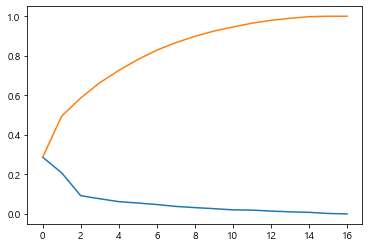

In [16]:
df2 = df.drop('CUST_ID', axis = 1)
df2 = StandardScaler().fit_transform(df2)

pca = PCA(random_state = 6)
pca.fit(df2)
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [17]:
evr = pd.DataFrame(df.drop('CUST_ID', axis = 1).columns, columns = ['Feature_Name'])
evr['EVR'] = pca.explained_variance_ratio_
evr['CUMSUM_EVR'] = np.cumsum(pca.explained_variance_ratio_)
evr

,Feature_Name,EVR,CUMSUM_EVR
0,BALANCE,0.286838,0.286838
1,BALANCE_FREQUENCY,0.207817,0.494656
2,PURCHASES,0.092257,0.586913
3,ONEOFF_PURCHASES,0.076696,0.663609
4,INSTALLMENTS_PURCHASES,0.062123,0.725732
5,CASH_ADVANCE,0.055120,0.780852
6,PURCHASES_FREQUENCY,0.047582,0.828434
7,ONEOFF_PURCHASES_FREQUENCY,0.037901,0.866335
8,PURCHASES_INSTALLMENTS_FREQUENCY,0.031992,0.898327
9,CASH_ADVANCE_FREQUENCY,0.026538,0.924865


In [18]:
pca = PCA(n_components = 8, random_state = 6)
data = pca.fit_transform(df2)
data

array([[-1.33344389e+00, -1.90872621e+00,  4.48879284e-01, ...,
         5.47815123e-01,  5.03377611e-01, -9.70008708e-02],
       [-2.26218005e+00,  3.97415160e+00,  8.95684768e-03, ...,
        -1.46697998e-01, -9.43009509e-02, -1.70966330e+00],
       [ 1.24749293e+00,  9.43694176e-01,  1.93925249e+00, ...,
        -3.97900554e-02, -1.67908915e+00,  1.14355804e+00],
       ...,
       [-3.35863963e-01, -2.34941655e+00, -1.39620209e+00, ...,
        -1.92993826e+00, -7.27633754e-01, -9.73540441e-01],
       [-2.19390938e+00, -1.89265892e+00, -1.09808100e-01, ...,
        -1.38895977e+00, -3.59537070e-01, -1.51852662e+00],
       [ 2.23719366e-03, -4.23665267e-01,  9.39834632e-01, ...,
        -1.60207956e+00,  3.70204773e-02,  3.76741120e-01]])

### 기계학습7     
위의 차원 축소된 데이터를 바탕으로 KMeans 클러스터링을 실시하라.     
응집도와 분리도를 기반으로 적절 클러스터 숫자를 구하고 두개의 주성분 차원에 군집 중심을 포함하여 시각화하라

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

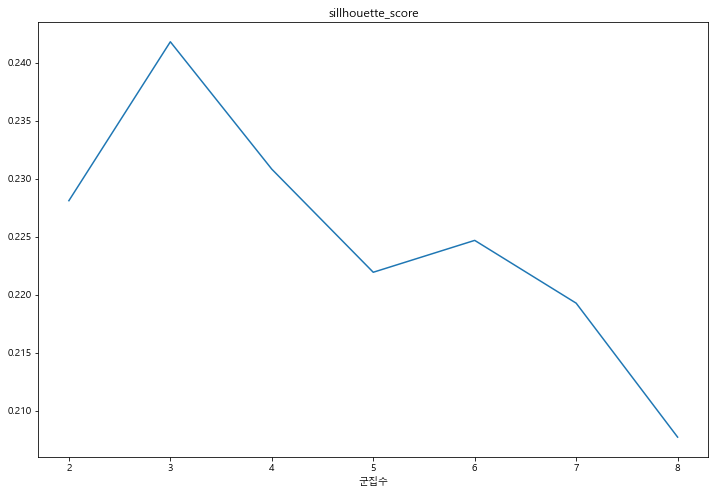

In [20]:
l1 = []

for i in range(2,9):
    k = KMeans(n_clusters = i, random_state = 27)
    k.fit(data)
    score = silhouette_score(data, k.predict(data))
    l1.append(score)
    
plt.figure(figsize = (12,8))
plt.plot([i for i in range(2,9)], l1)
plt.title('sillhouette_score')
plt.xlabel('군집수')
plt.show()

In [21]:
kmean = KMeans(n_clusters = 3, random_state = 27)
kmean.fit(data)
result = pd.DataFrame(data, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
result['label'] = kmean.predict(data)
result

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,label
0,-1.333444,-1.908726,0.448879,-0.567592,-0.183619,0.547815,0.503378,-0.097001,0
1,-2.262180,3.974152,0.008957,0.930881,2.689651,-0.146698,-0.094301,-1.709663,2
2,1.247493,0.943694,1.939252,-1.133478,-0.957058,-0.039790,-1.679089,1.143558,1
3,-0.613178,0.472947,2.080693,-0.890053,0.261908,-1.255123,0.265936,0.391102,0
4,-1.397063,-1.218912,0.684153,-0.835984,-0.287428,0.919533,0.103180,-0.665943,0
...,...,...,...,...,...,...,...,...,...
7514,0.379382,-2.293899,-1.979383,1.679219,-2.375084,-1.564753,-1.338809,-1.406238,0
7515,-0.064045,-1.280739,-1.950135,0.224219,-2.991382,-2.176448,-0.430406,-1.139269,0
7516,-0.335864,-2.349417,-1.396202,1.439425,-2.517306,-1.929938,-0.727634,-0.973540,0
7517,-2.193909,-1.892659,-0.109808,2.044605,-2.368926,-1.388960,-0.359537,-1.518527,0


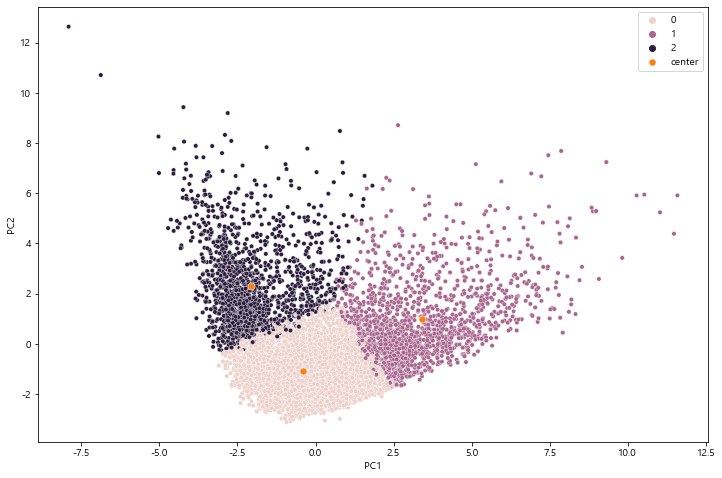

In [22]:
plt.figure(figsize = (12,8))
sns.scatterplot(data = result, x = 'PC1', y = 'PC2', hue = 'label', s = 20)
sns.scatterplot(x = kmean.cluster_centers_[:,0],y =kmean.cluster_centers_[:,1],label='center', s = 50)
plt.show()

### 기계학습8   
마케팅 담당자인 당신은 KMeans 군집 결과를 통해 각 군집 특성을 파악하고 군집별 프로모션 전략을 서술하라
    

### 기계학습9
병합적 계층군집을 실시하고 덴드로그램을 시각화하라. 군집간 거리는 ward 방식으로 업데이트하며 위 문제에서 구한 최적 군집 갯수가 만들어지 지기 위한 거리 범위를 구하라

In [23]:
from scipy.cluster.hierarchy import linkage, dendrogram

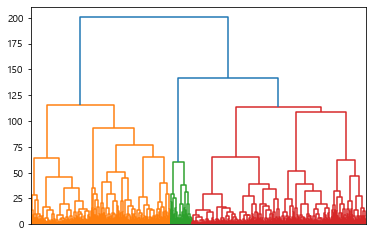

In [24]:
hclust = linkage(data, 'ward')
d = dendrogram(hclust)
plt.xticks([])
plt.show()

In [40]:
thr = pd.DataFrame(d['dcoord'])
thr

,0,1,2,3
0,0.000000,1.673085,1.673085,0.000000
1,0.000000,0.968819,0.968819,0.000000
2,0.000000,1.185789,1.185789,0.000000
3,0.968819,2.092272,2.092272,1.185789
4,0.000000,1.022974,1.022974,0.000000
...,...,...,...,...
7513,32.660034,61.847920,61.847920,46.783635
7514,52.079295,108.984057,108.984057,61.847920
7515,64.833907,113.334758,113.334758,108.984057
7516,60.260234,142.028029,142.028029,113.334758


In [34]:
thr[thr[2] >70]

,0,1,2,3
3146,50.728211,76.651640,76.651640,65.391041
3147,34.841851,92.865653,92.865653,76.651640
3148,63.978552,115.340454,115.340454,92.865653
7514,52.079295,108.984057,108.984057,61.847920
7515,64.833907,113.334758,113.334758,108.984057
7516,60.260234,142.028029,142.028029,113.334758
7517,115.340454,200.596585,200.596585,142.028029


# 통계 (40점)

### 통계1      
어느 자동차 회사의 본사에서 여러 지방 영업소에 내려보낸 43대의 새 차 중 11대에 불량 오디오가 설치되었다고 한다. 어느 영업소가 8대를 인수하였는데 이 중에서 오디오가 불량인 차가 적어도 2대 이상이 될 확률을 구하라.

### 통계2
data_path = ./data/stats_reg1.csv     
종속변수 : Target   
독립변수 : 다양한 센서데이터

### 통계2-1
변수들의 다중공선성을 검토하라


### 통계2-2
다중공선성 문제를 해결하기 위한 방법 2가지를 제시하고, 하나를 선택하여 적용하라


### 통계2-3
2-2의 방법을 전,후의 회귀 분석 모델의 결과를 비교하라


### 통계 3     
data_path = ./data/learn.csv
- 어느 학급의 학생들이 3가지(Lecture,Online,Blended)방식으로 학습하고 시험을 본 결과이다.


In [453]:
import pandas as pd
df = pd.read_csv('./data/learn.csv')
df.head()

,Student,Lecture,Online,Blended
0,1,8.7,67.8,74.2
1,2,18.2,97.2,76.5
2,3,7.5,74.8,69.1
3,4,39.7,62.3,68.4
4,5,73.4,84.9,84.5


### 통계 3-1
3가지 방식 각각 점수 분포가 정규성을 만족하는지와 방식들간의 분산은 동일한지 검정하라

### 통계 3-2
위 결과에 맞는 그룹간 점수 분포 차이가 존재하는지를 확인하는 통계 검정 전략을 설명하라

### 통계 3-3
가설에 따른 검정을 수행하고, 검정통계량과 p-value를 설명하라